# Comparisson between different pre trained models on ImageNet

## Common Parameters

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from PIL import features, Image
from packaging import version
import tensorflow as tf
import platform
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import tensorflow.keras
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from visuals import *
from data import *
from collections import Counter
from data.data_loader import *
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, recall_score, accuracy_score, roc_auc_score
from metrics import balanced_accuracy
from helpers import *
import random
from pathlib import Path

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019/sampled_unbalanced_5000'

model_folder = 'models'
history_folder = 'history'
pred_result_folder_test = 'test_predict_results'
out_dist_pred_result_folder = 'out_dist_predict_results'

models_info = read_models_info(history_folder, pred_result_folder_test)

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Training Data

Number of known categories: 8
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 

Number of unknown categories: 1
UNK 

Category to Index:
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7, 'UNK': 8} 

Training data has 5000 samples.
'MEL':	892	(17.84%)
'NV':	2541	(50.82%)
'BCC':	655	(13.10%)
'AK':	171	(3.42%)
'BKL':	517	(10.34%)
'DF':	47	(0.94%)
'VASC':	49	(0.98%)
'SCC':	128	(2.56%)
'UNK':	0	(0.00%)


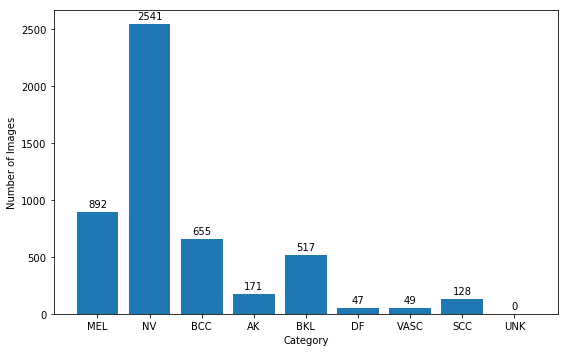

In [3]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(training_image_folder, ground_truth_file)
known_category_num = len(known_category_names)
print("Number of known categories: {}".format(known_category_num))
print(known_category_names, '\n')
unknown_category_num = 1
print("Number of unknown categories: {}".format(unknown_category_num))
print(unknown_category_name, '\n')
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

# mapping from category to index
print('Category to Index:')
category_to_index = dict((c, i) for i, c in enumerate(all_category_names))
print(category_to_index, '\n')

count_per_category = Counter(df_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Training data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

df_ground_truth.head()

df_all_ground_truth, _, _ = load_isic_training_data(
    "../data/isic2019/ISIC_2019_Training_Input", 
    "../data/isic2019/ISIC_2019_Training_GroundTruth.csv"
)

### Shuffle and Split Training Data into Training  and Validation Sets

In [3]:
df_train, df_val = train_validation_split(df_ground_truth)

# Training Set
sample_count_train = df_train.shape[0]
print("Training set has {} samples.".format(sample_count_train))
count_per_category_train = Counter(df_train['category'])
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

# Validation Set
sample_count_val = df_val.shape[0]
print("\nValidation set has {} samples.".format(sample_count_val))

Training set has 4000 samples.
'MEL':	714	(17.85%)
'NV':	2033	(50.83%)
'BCC':	524	(13.10%)
'AK':	137	(3.42%)
'BKL':	414	(10.35%)
'DF':	37	(0.93%)
'VASC':	39	(0.97%)
'SCC':	102	(2.55%)
'UNK':	0	(0.00%)

Validation set has 1000 samples.


### Class Weights based on the Traning Set

Class Weights (without UNK):
'MEL':	0.700280
'NV':	0.245942
'BCC':	0.954198
'AK':	3.649635
'BKL':	1.207729
'DF':	13.513514
'VASC':	12.820513
'SCC':	4.901961


/home/fmts/miniconda3/envs/experiments/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=3851    1
1930    1
745     1
4063    1
1272    1
       ..
1980    0
2371    0
4837    1
1351    1
810     2
Name: category, Length: 4000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


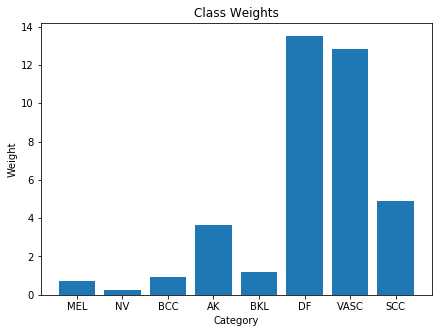

In [153]:
class_weights = compute_class_weight_dict(df_train)
print('Class Weights (without UNK):')
for i, c in enumerate(known_category_names):
    print("'%s':\t%f" % (c, class_weights[i]))

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(known_category_names, [class_weights[i] for i in range(known_category_num)]);

## Transfer Learning

### Complexity Graph of Transfer Learning Models

../history/DenseNet201/DenseNet201.training.csv
../history/EfficientNetB0/EfficientNetB0.training.csv
../history/EfficientNetB1/EfficientNetB1.training.csv
../history/EfficientNetB2/EfficientNetB2.training.csv
../history/EfficientNetB3/EfficientNetB3.training.csv
../history/EfficientNetB4/EfficientNetB4.training.csv
../history/VGG16/VGG16.training.csv
../history/VGG19/VGG19.training.csv
../history/ResNet50/ResNet50.training.csv


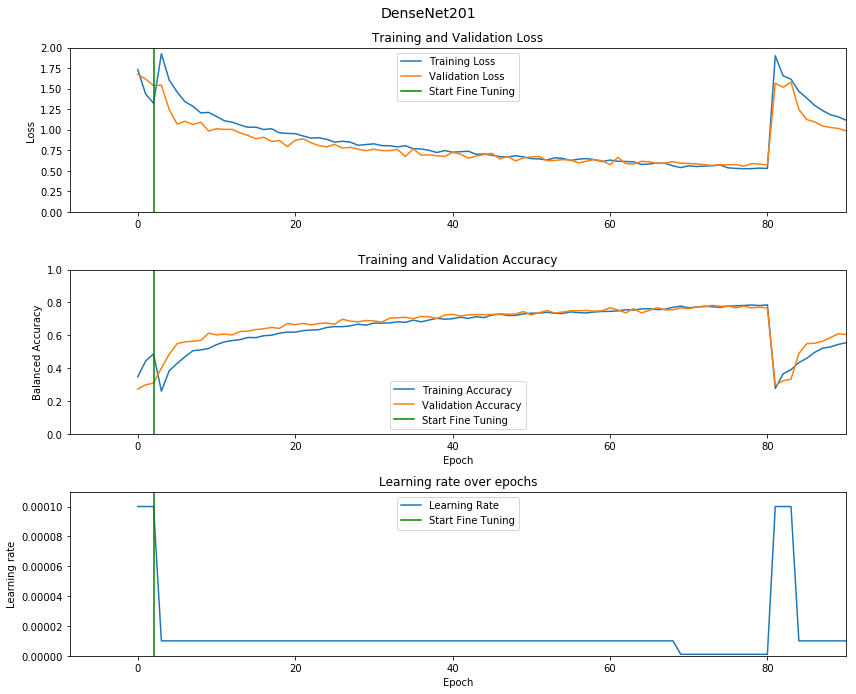

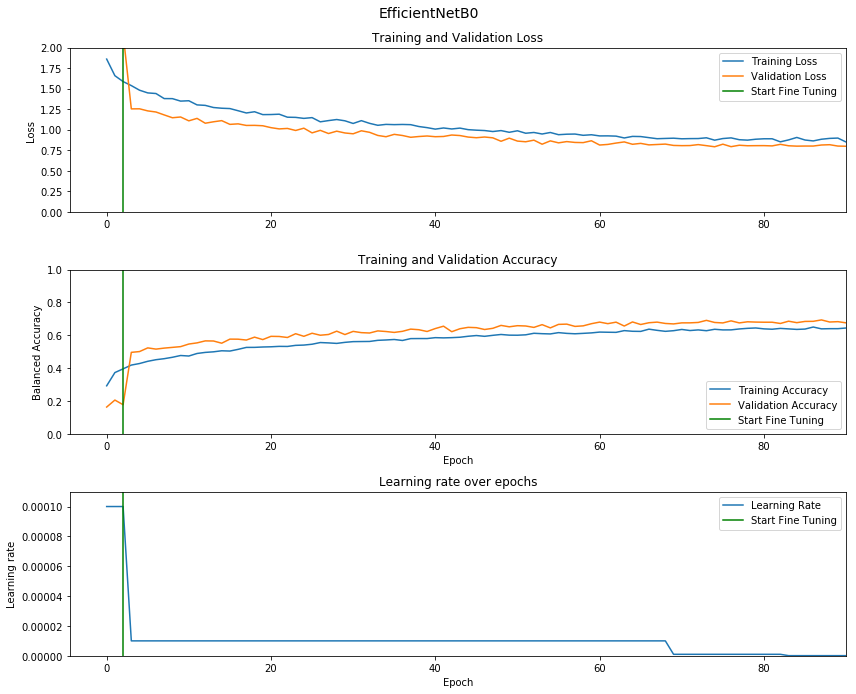

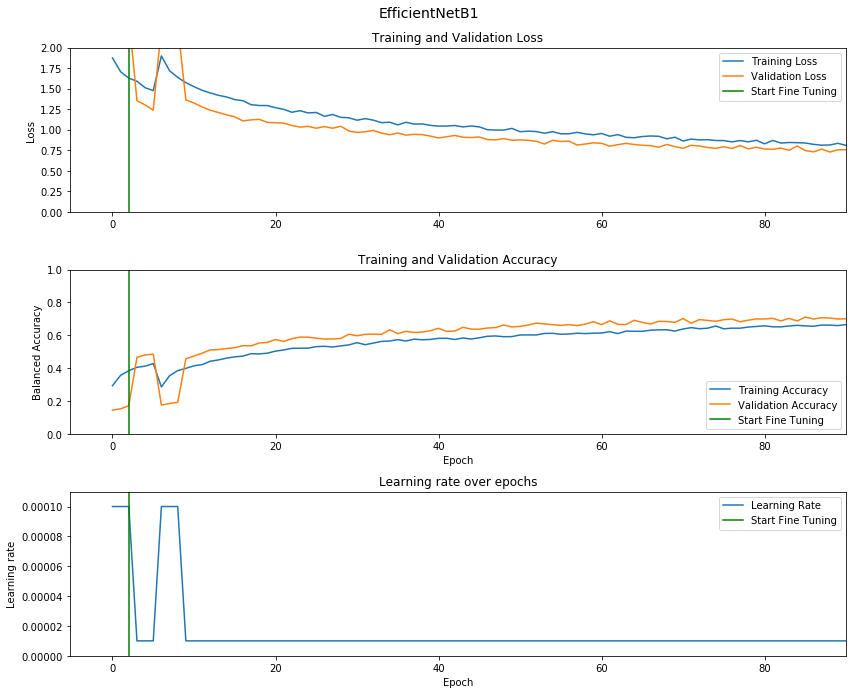

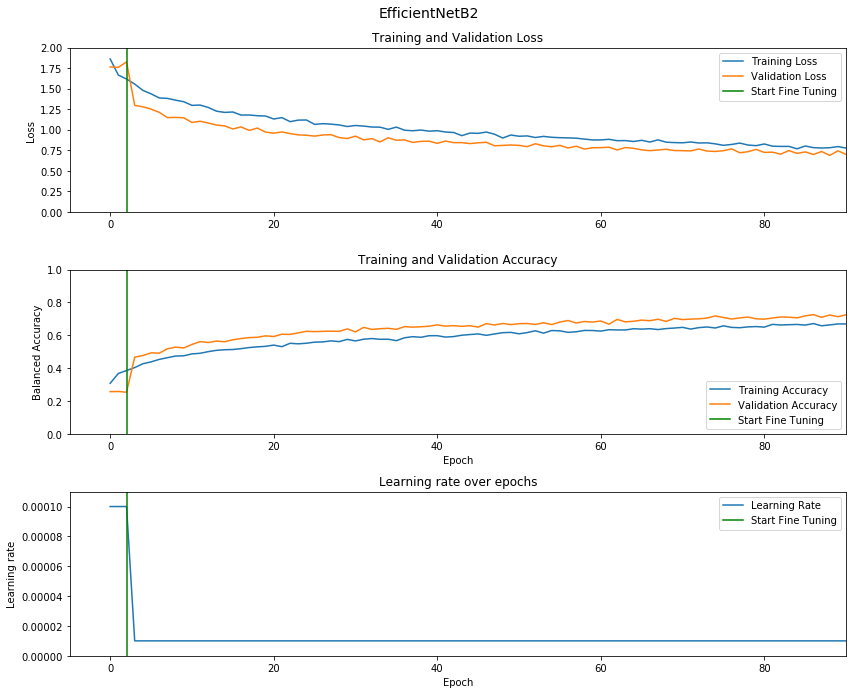

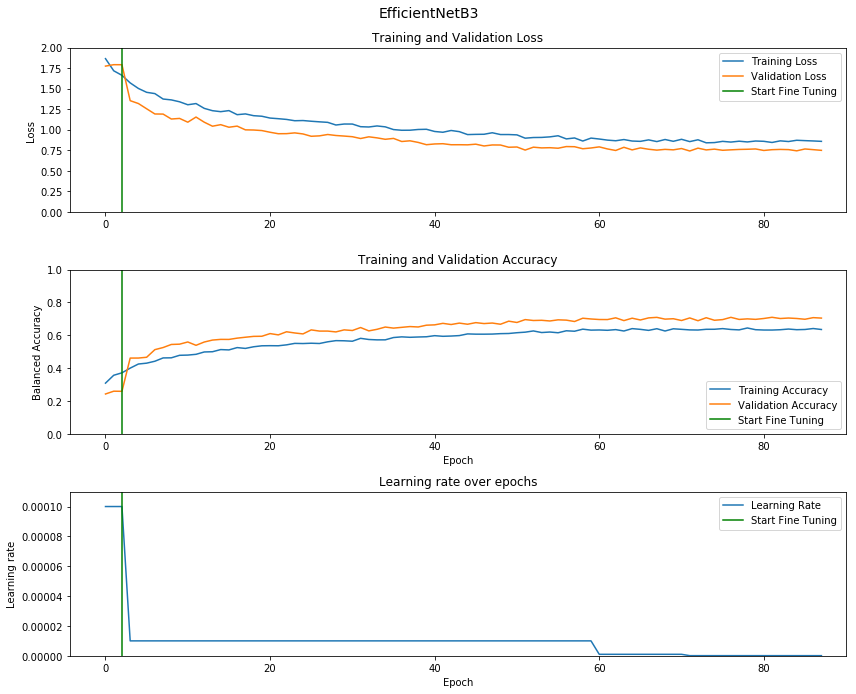

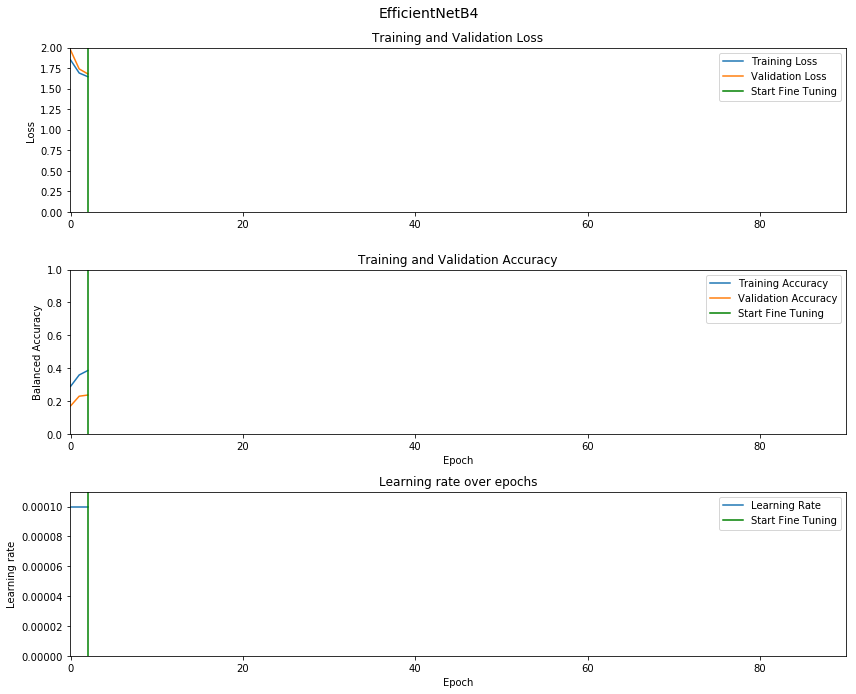

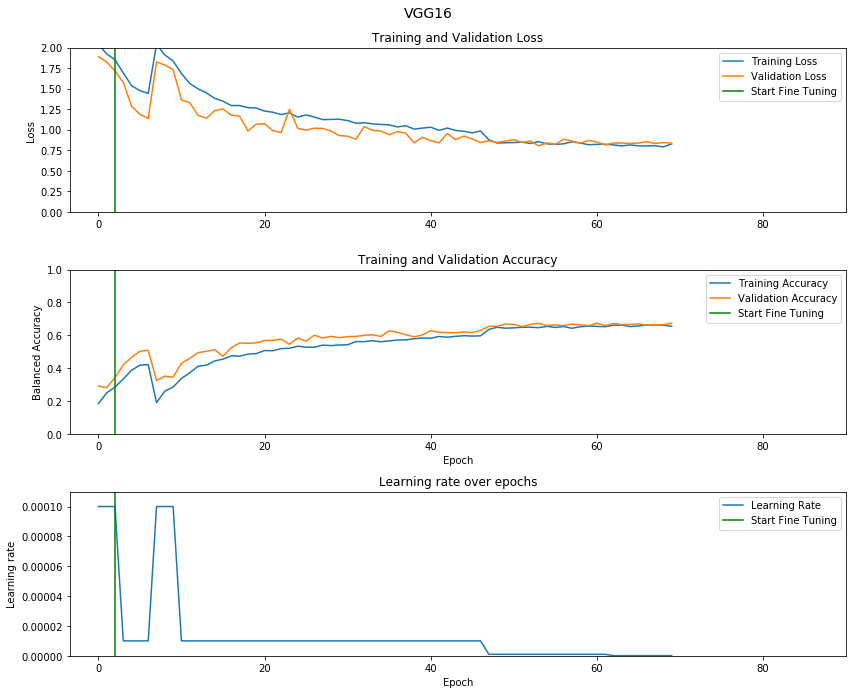

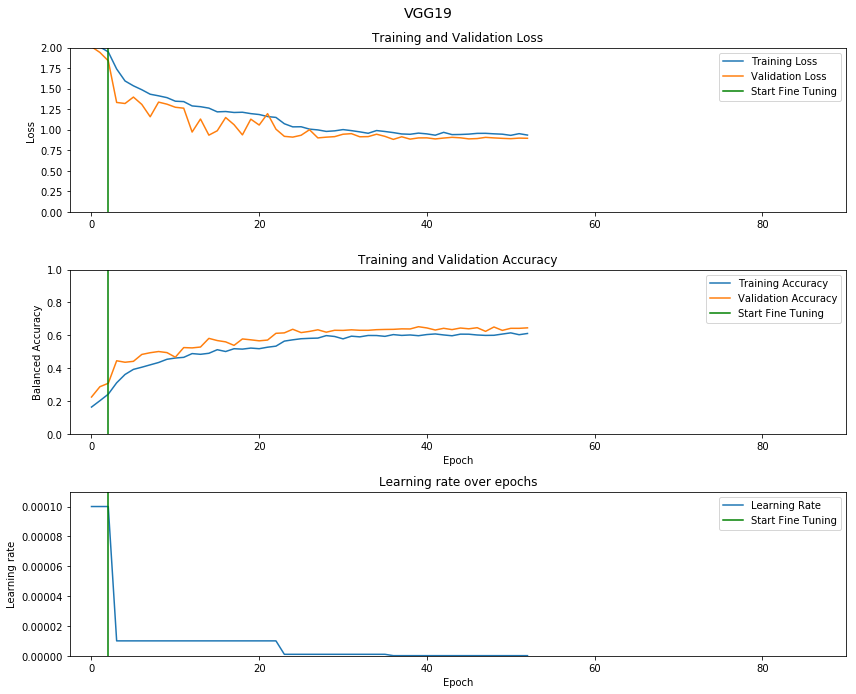

In [13]:
model_names = ['DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'VGG16', 'VGG19', 'ResNet50']
feature_extract_epochs = 3

for model_name in model_names:
    file_path = os.path.join("..", history_folder, model_name, "{}.training.csv".format(model_name))
    print(file_path)
    if os.path.exists(file_path):
        fig = plot_complexity_graph(csv_file=file_path,
                              title="{}".format(model_name),
                              figsize=(12, 10),
                              feature_extract_epochs=feature_extract_epochs)
        fig.savefig(os.path.join("..", history_folder, model_name, "{}.training.svg".format(model_name)), format='svg',
                    bbox_inches='tight', pad_inches=0)

### Softmax examples

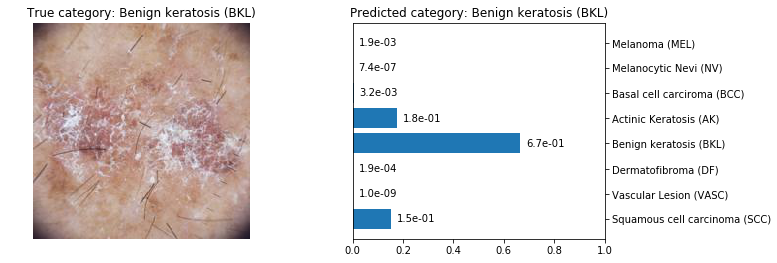

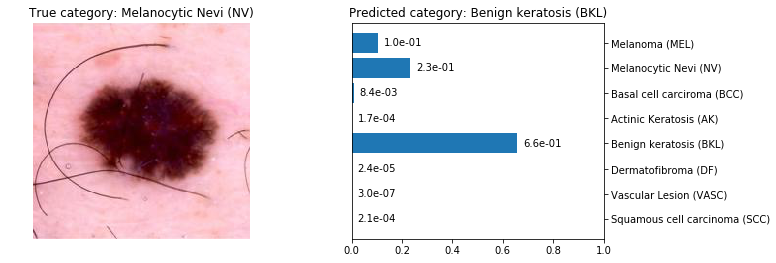

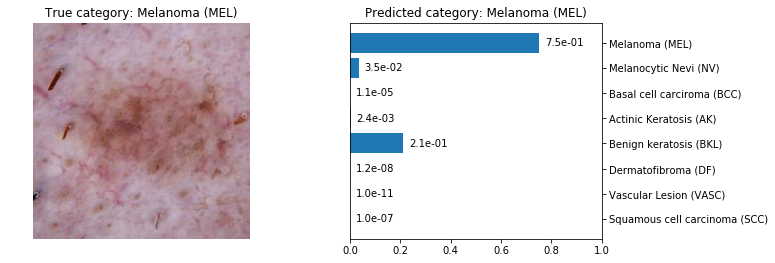

In [112]:
history_folder = 'history_proper'
pred_result_folder_test = 'test_predict_results_proper'
model = filter_models_info(
    read_models_info(history_folder, pred_result_folder_test), 
    models=["DenseNet121"],
    parameters={
        "balanced": 0,
        "feepochs": 2, 
        "ftepochs": 100, 
        "felr": 0.001,
        "ftlr": 0.0001,
        "batch": 32,
        "lambda": None,
        "dropout": None,
        "samples": 20517,
        "dggroup": 00
    },
)[0]

ground_truth, _, _ = load_isic_training_data(
    "../data/isic2019/sampled_original_10_val_10_test/ISIC_2019_Test_Input", 
    "../data/isic2019/sampled_original_10_val_10_test/ISIC_2019_Test_GroundTruth.csv"
)
df_pred = pd.read_csv(os.path.join(model["pred_test"], "no_unknown", "best_balanced_acc.csv"))
df = pd.merge(df_pred, ground_truth, on='image')
y_true = df['category']
y_pred = df['pred_category']

imgs_crop_marker = [
    "ISIC_0028972",
    "ISIC_0000201_downsampled",
    "ISIC_0028220"
]

names = [
    "Melanoma (MEL)", 
    "Melanocytic Nevi (NV)", 
    "Basal cell carciroma (BCC)", 
    "Actinic Keratosis (AK)", 
    "Benign keratosis (BKL)",
    "Dermatofibroma (DF)",
    "Vascular Lesion (VASC)",
    "Squamous cell carcinoma (SCC)"
]

for img_path in imgs_crop_marker:
    values = df.loc[df['image'] == img_path].values.tolist()[0]
    probs = values[1:9]
    img_path = values[len(values)-2]
    true_class = values[len(values)-1]
    predicted_class = values[10]
    fig = plot_prob_bars(
        img_title_true='True category: ' + str(names[true_class]),
        img_title_predicted='Predicted category: ' + str(names[predicted_class]),
        img_path=img_path,
        labels=names,
        probs=probs,
        topk=8
    )
    fig.savefig("softmax_probs.jpg", format='pdf', dpi=150, bbox_inches='tight', pad_inches=0)

## Predict Validation Set

### Load Prediction Results on Validation Set

Model selection criteria:  latest
../val_predict_results/VGG16/balanced_0-samples_5000-feepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32/no_unknown/latest.csv
========== VGG16 ==========
balanced_accuracy_score:  0.6041313851092163
macro recall_score:  0.6041313851092163
categorical_crossentropy:  0.8282701631271616
weighted categorical_crossentropy:  1.4549027196422586

../val_predict_results/VGG19/balanced_0-samples_5000-feepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32/no_unknown/latest.csv
========== VGG19 ==========
balanced_accuracy_score:  0.5064048953989067
macro recall_score:  0.5064048953989067
categorical_crossentropy:  0.8307733613057584
weighted categorical_crossentropy:  1.6605932923233613

../val_predict_results/ResNet50/balanced_0-samples_5000-feepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32/no_unknown/latest.csv
========== ResNet50 ==========
balanced_accuracy_score:  0.5816995193920573
macro recall_

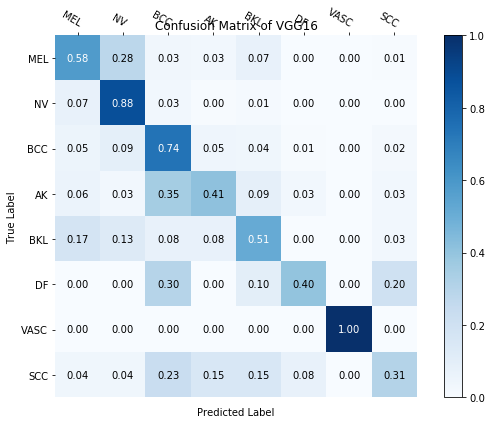

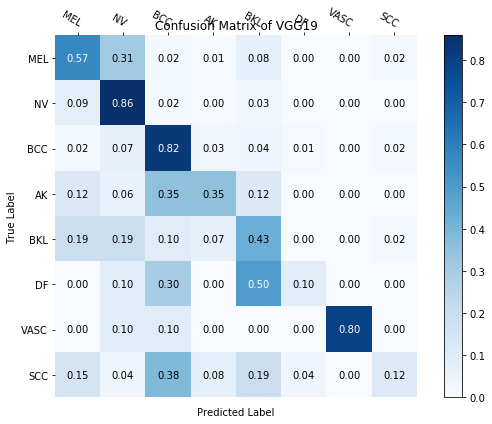

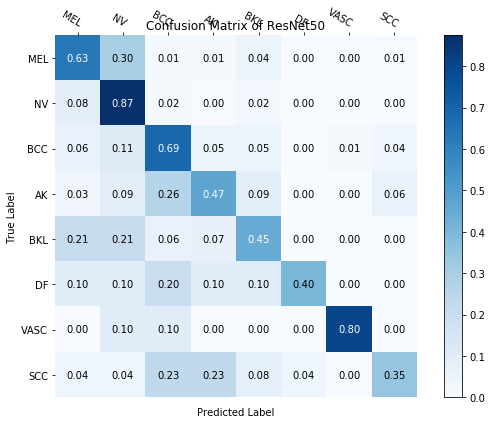

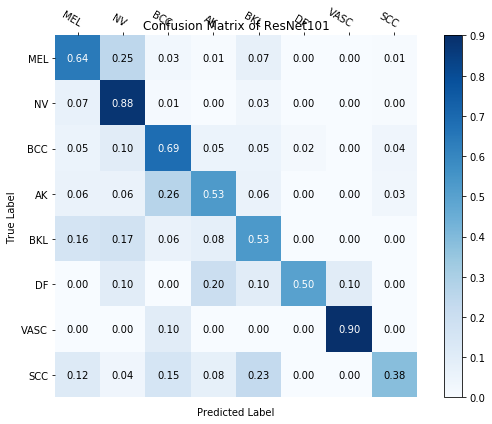

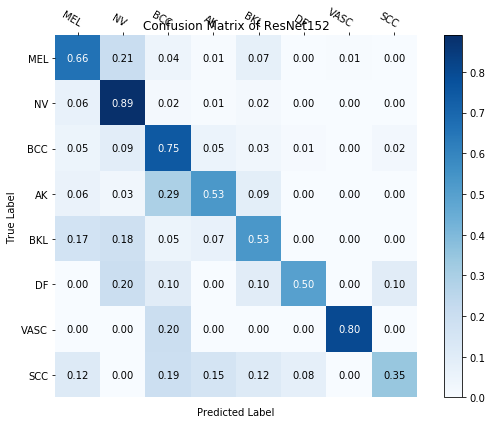

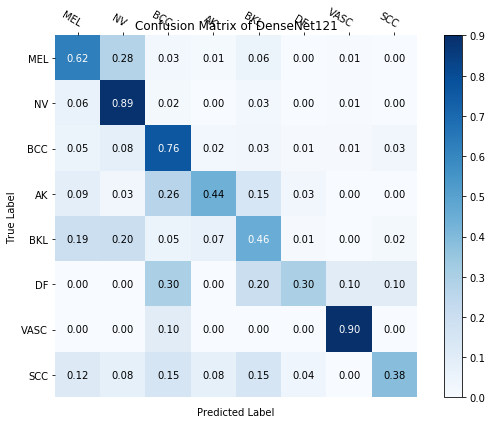

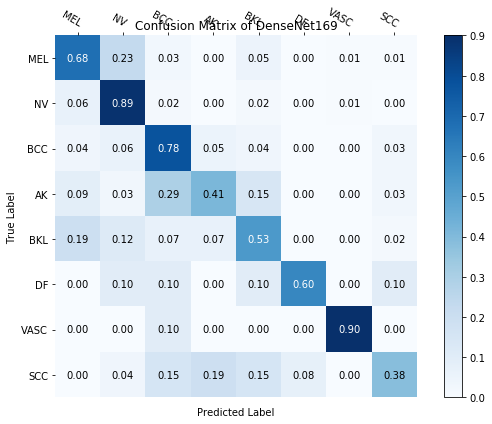

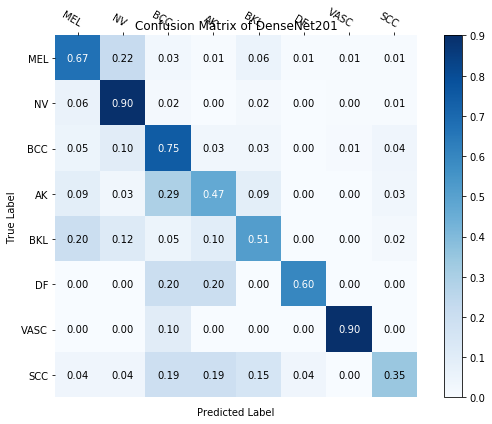

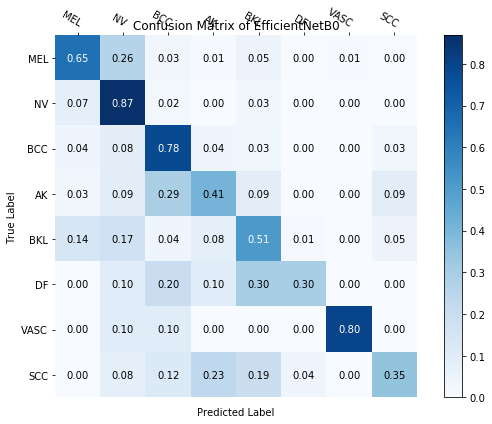

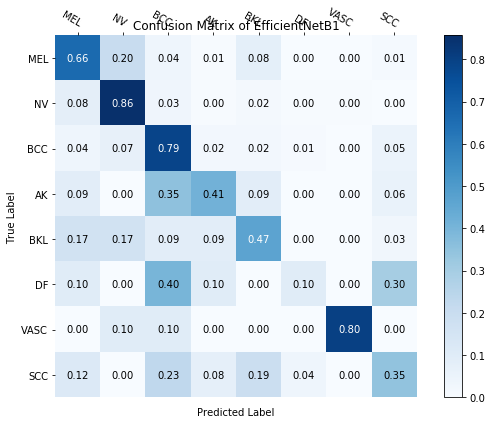

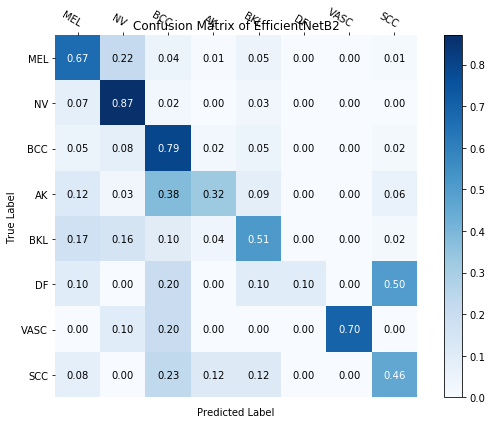

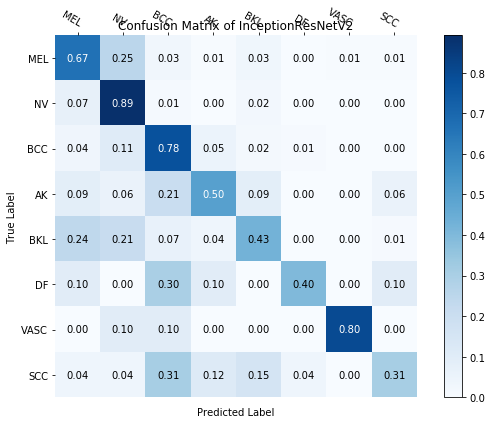

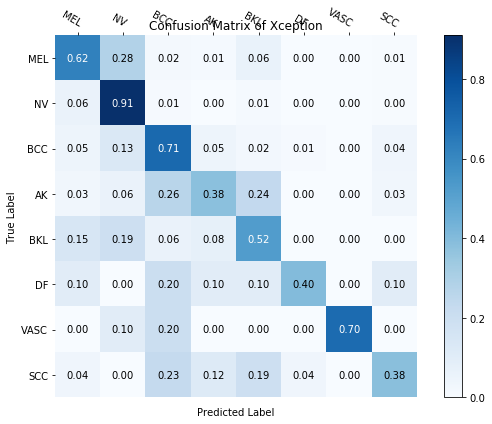

In [31]:
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy
model_names = [
    'VGG16',
    'VGG19',
    'ResNet50',
    'ResNet101',
    'ResNet152',
    'DenseNet121',
    'DenseNet169',
    'DenseNet201', 
    'EfficientNetB0', 
    'EfficientNetB1', 
    'EfficientNetB2', 
    'EfficientNetB3',  
    'InceptionResNetV2', 
    'Xception'
    #'Ensemble'
]

postfix = 'latest'
print('Model selection criteria: ', postfix)

for model_name in model_names:
    # Load predicted results
    file_path = os.path.join("..", pred_result_folder_test, model_name, hyperparameter_str, "no_unknown", "{}.csv".format(postfix))

    print(file_path)
    if not os.path.exists(file_path):
        continue

    print("========== {} ==========".format(model_name))
    df = pd.read_csv(file_path)
    y_true = df['category']
    y_pred = df['pred_category']

    # Compute Balanced Accuracy
    print('balanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))
    print('macro recall_score: ', recall_score(y_true, y_pred, average='macro'))

    # Compute categorical_crossentropy
    y_true_onehot = utils.to_categorical(df['category'], num_classes=known_category_num)
    y_pred_onehot = np.array(df.iloc[:,1:9])
    print('categorical_crossentropy: ',
          np.average(categorical_crossentropy(y_true_onehot, y_pred_onehot)))

    # Compute weighted categorical_crossentropy
    print('weighted categorical_crossentropy: ',
          np.average(categorical_crossentropy(y_true_onehot, y_pred_onehot, class_weights=class_weights)))

    # Confusion Matrix
    fig = plot_confusion_matrix(y_true, y_pred, known_category_names, normalize=True,
                                title="Confusion Matrix of {}".format(model_name),
                                figsize=(8, 6))
    print('')

Validation set has 1000 samples.

========== Ground Truth ==========
'MEL':	178	(17.80%)
'NV':	508	(50.80%)
'BCC':	131	(13.10%)
'AK':	34	(3.40%)
'BKL':	103	(10.30%)
'DF':	10	(1.00%)
'VASC':	10	(1.00%)
'SCC':	26	(2.60%)

========== VGG16 Prediction ==========
'MEL':	168	(16.80%)
'NV':	524	(52.40%)
'BCC':	147	(14.70%)
'AK':	39	(3.90%)
'BKL':	85	(8.50%)
'DF':	8	(0.80%)
'VASC':	10	(1.00%)
'SCC':	19	(1.90%)

========== VGG19 Prediction ==========
'MEL':	176	(17.60%)
'NV':	525	(52.50%)
'BCC':	157	(15.70%)
'AK':	28	(2.80%)
'BKL':	93	(9.30%)
'DF':	3	(0.30%)
'VASC':	8	(0.80%)
'SCC':	10	(1.00%)

========== ResNet50 Prediction ==========
'MEL':	188	(18.80%)
'NV':	539	(53.90%)
'BCC':	124	(12.40%)
'AK':	39	(3.90%)
'BKL':	77	(7.70%)
'DF':	5	(0.50%)
'VASC':	10	(1.00%)
'SCC':	18	(1.80%)

========== ResNet101 Prediction ==========
'MEL':	176	(17.60%)
'NV':	527	(52.70%)
'BCC':	121	(12.10%)
'AK':	39	(3.90%)
'BKL':	100	(10.00%)
'DF':	7	(0.70%)
'VASC':	11	(1.10%)
'SCC':	19	(1.90%)

========== ResNet152 Pre

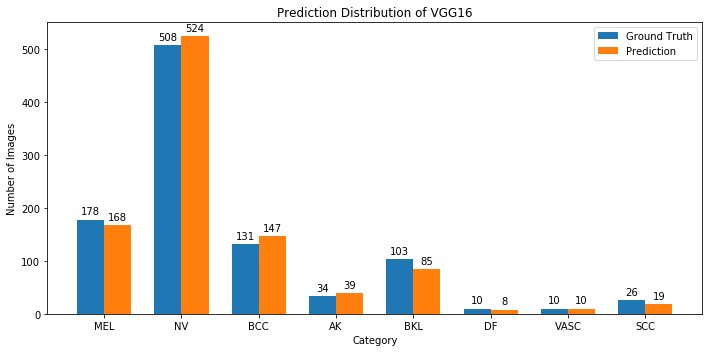

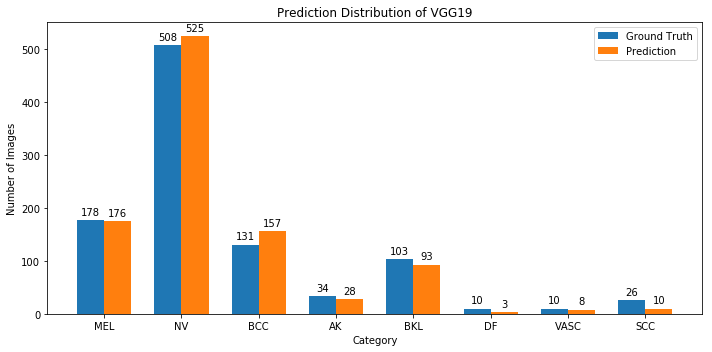

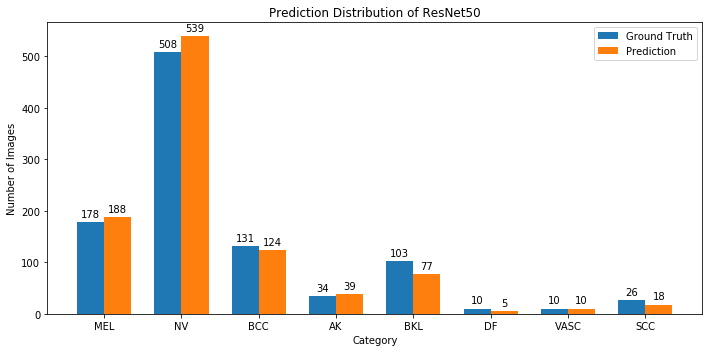

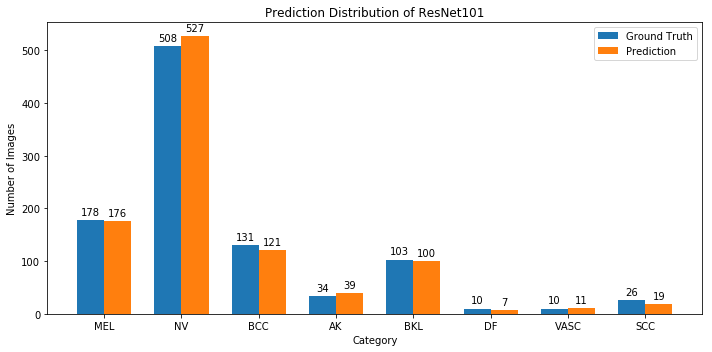

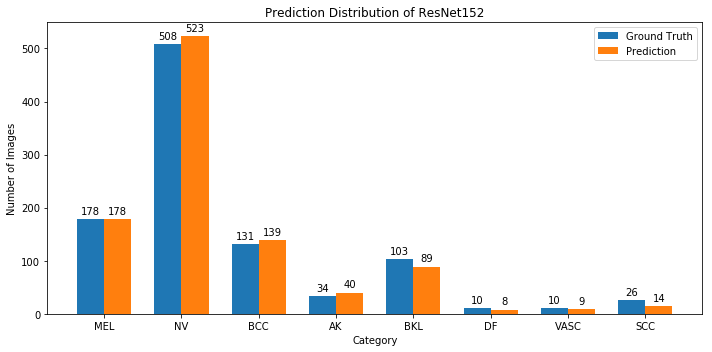

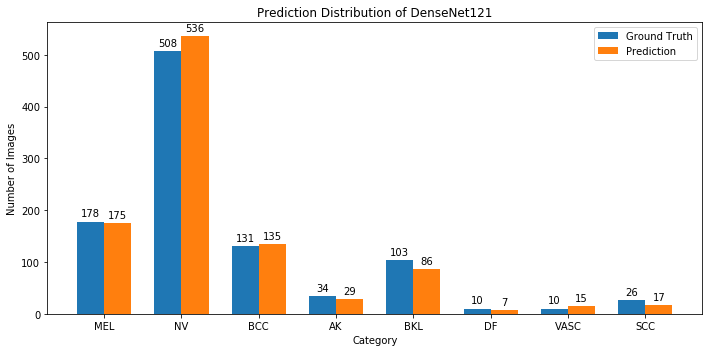

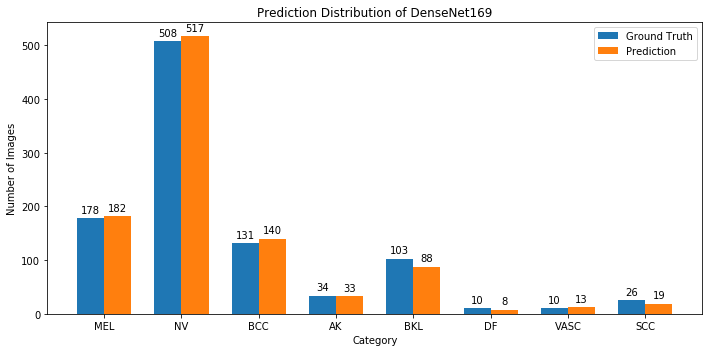

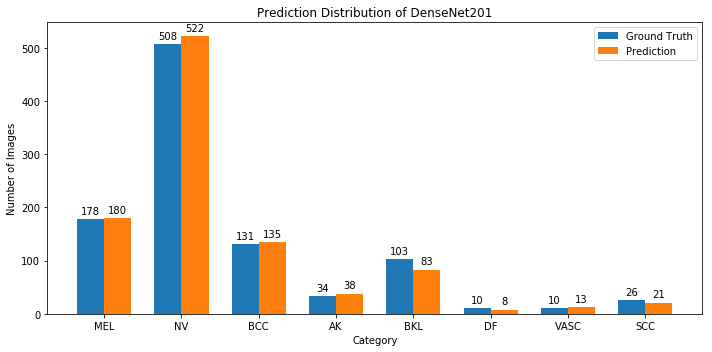

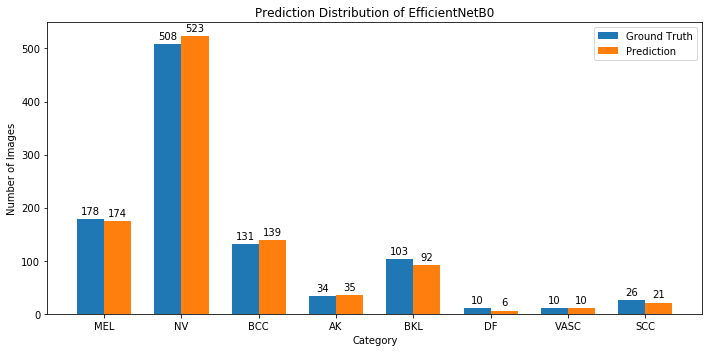

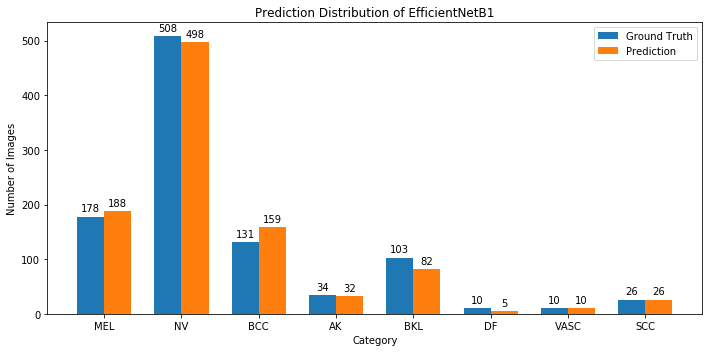

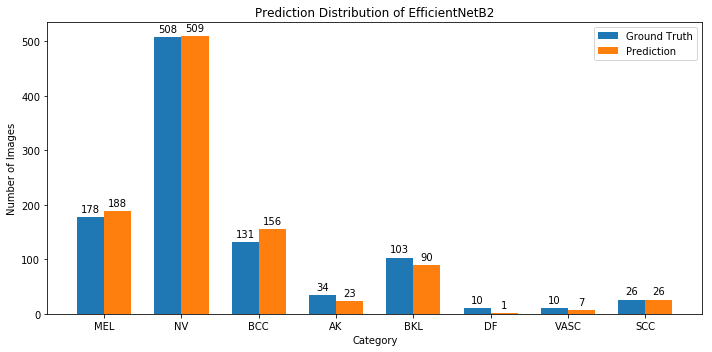

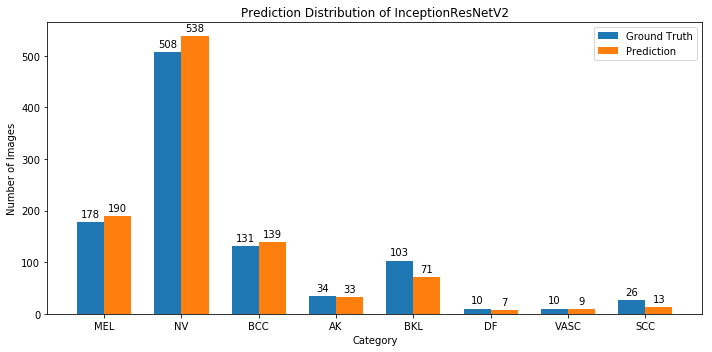

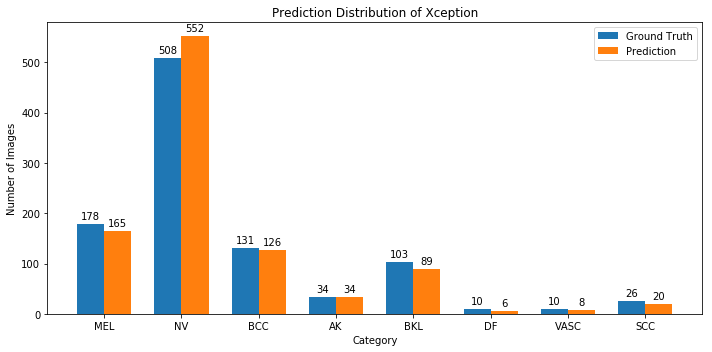

In [33]:
sample_count_val = y_true.shape[0]
print("Validation set has {} samples.\n".format(sample_count_val))

print('========== Ground Truth ==========')
count_true = Counter(y_true)
for i, c in enumerate(known_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_true[i], count_true[i]*100/sample_count_val))

for model_name in model_names:
    # Load predicted results
    file_path = os.path.join("..", pred_result_folder_test, model_name, hyperparameter_str, "no_unknown", "{}.csv".format(postfix))
    if not os.path.exists(file_path):
        continue

    print("\n========== {} Prediction ==========".format(model_name))
    df = pd.read_csv(file_path)
    y_pred = df['pred_category']
    
    count_pred = Counter(y_pred)
    for i, c in enumerate(known_category_names):
        print("'%s':\t%d\t(%.2f%%)" % (c, count_pred[i], count_pred[i]*100/sample_count_val))

    # Plot Prediction Distribution
    plot_grouped_2bars(
        scalars=[[count_true[i] for i in range(known_category_num)],
                 [count_pred[i] for i in range(known_category_num)]],
        scalarlabels=['Ground Truth', 'Prediction'],
        xticklabels=known_category_names,
        xlabel='Category',
        ylabel='Number of Images',
        title="Prediction Distribution of {}".format(model_name)
    )

{'model': 'VGG16', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '100', 'ftepochs': '0', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/VGG16/balanced_0-samples_5000-feepochs_100-ftepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_val': None, 'pred_test': '../test_predict_results/VGG16/balanced_0-samples_5000-feepochs_100-ftepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01'}
{'model': 'ResNet152', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '100', 'ftepochs': '0', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/ResNet152/balanced_0-samples_5000-feepochs_100-ftepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_val': None, 'pred_test': '../test

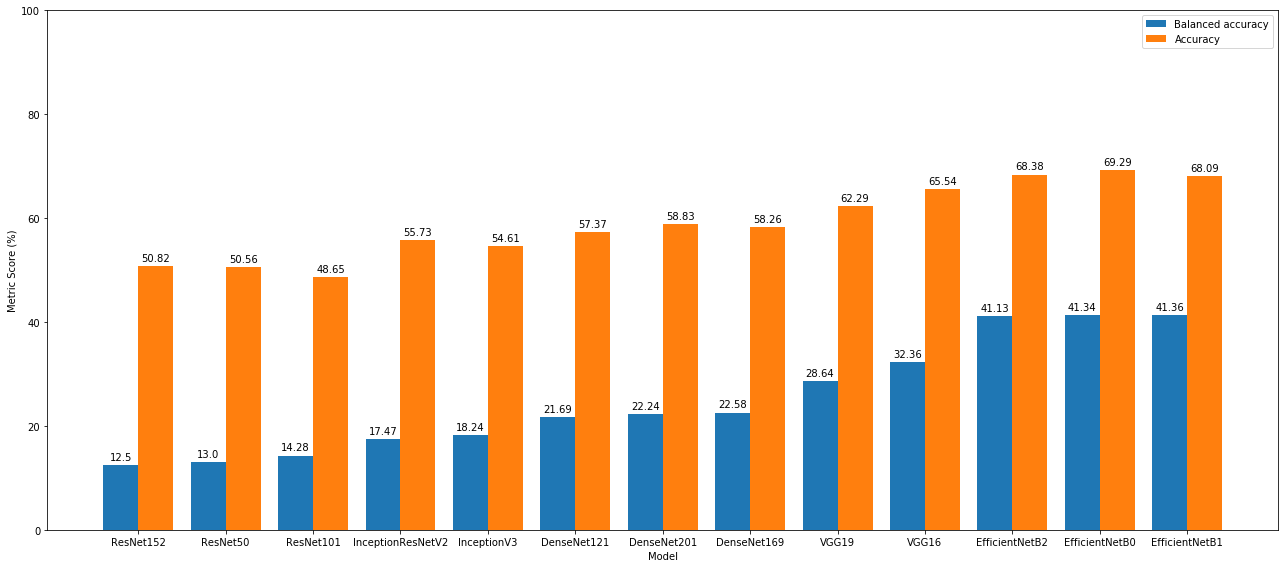

In [47]:
#print(models_info)
fig = plot_model_comparisson(
    models_info, 
    df_all_ground_truth,
    [balanced_accuracy_score, accuracy_score],
    ["Balanced accuracy", "Accuracy"],
    constant_parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "100",
        "ftepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "01"
    },
    figsize = (18,8)
)

fig.savefig(os.path.join("pre_trained_models_classifier_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

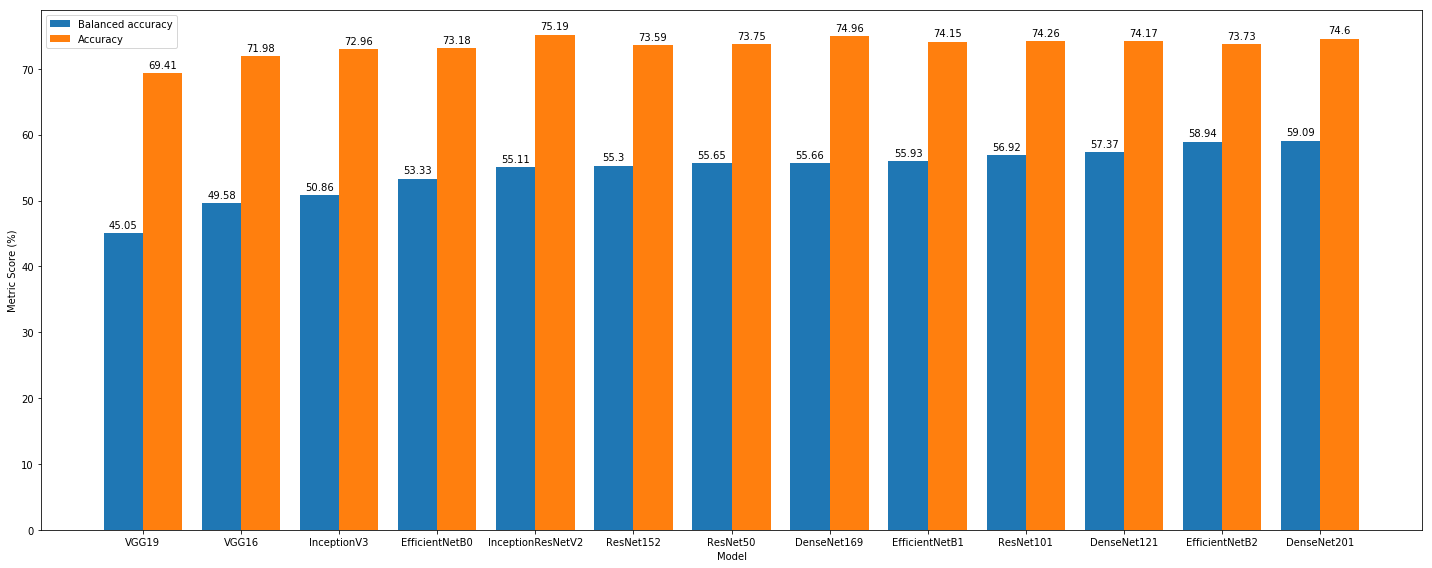

In [10]:
fig = plot_model_comparisson(
    models_info, 
    df_all_ground_truth,
    [balanced_accuracy_score, accuracy_score],
    ["Balanced accuracy", "Accuracy"],
    constant_parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftepochs": "100",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    },
    figsize = (20,8),
    y_max=None
)

#fig.savefig(os.path.join("pre_trained_models_ft_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

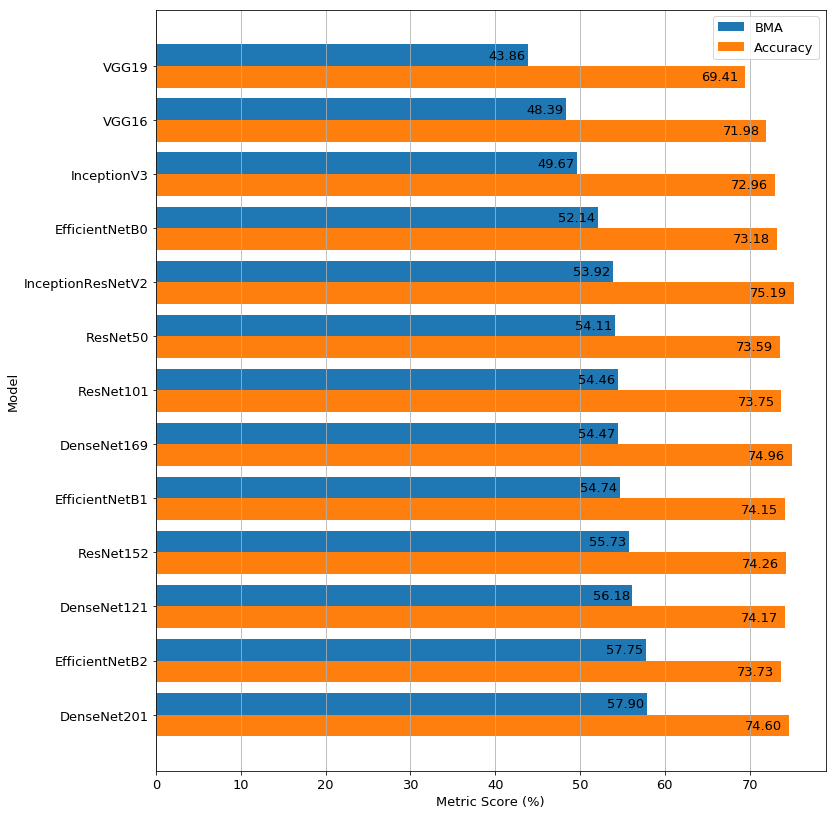

In [9]:
import matplotlib 

font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

fig = plot_model_comparisson(
    models_info, 
    df_all_ground_truth,
    [balanced_accuracy_score, accuracy_score],
    ["BMA", "Accuracy"],
    constant_parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftepochs": "100",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    },
    figsize = (12,14),
    y_max=None
)

fig.savefig(os.path.join("pre_trained_models_ft_comp_horizontal.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

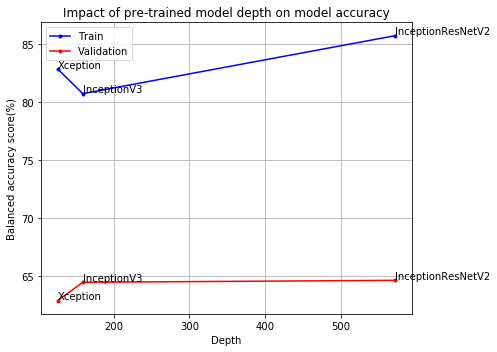

In [84]:
# Trainable params
model_layers = {
    'Xception': 126,  
    "InceptionV3": 159,
    'InceptionResNetV2': 572, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model depth on model accuracy"
)

{'model': 'VGG16', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '11'}, 'log': '../history/VGG16/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/0/training.csv', 'pred_test_0': '../test_predict_results/VGG16/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/0', 'pred_test': '../test_predict_results/VGG16/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11'}
{'model': 'VGG19', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '11'}, 'log': '../history/VGG19/balanced_0-samples_5000-feepochs

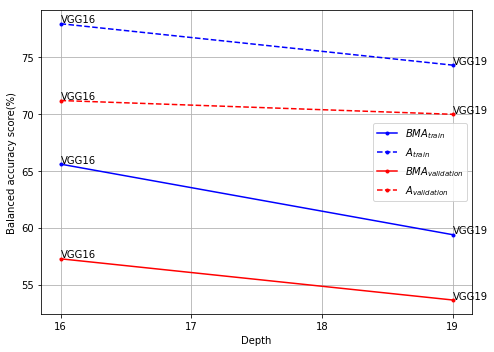

In [166]:
# Trainable params
model_layers = {
    'VGG16': 16, 
    'VGG19': 19, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(7,5),
    x_int_ticks=True
)

fig.savefig(os.path.join("vgg_depth.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

[{'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_test_0': '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0', 'pred_test': '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01'}, {'model': 'DenseNet121', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/DenseN

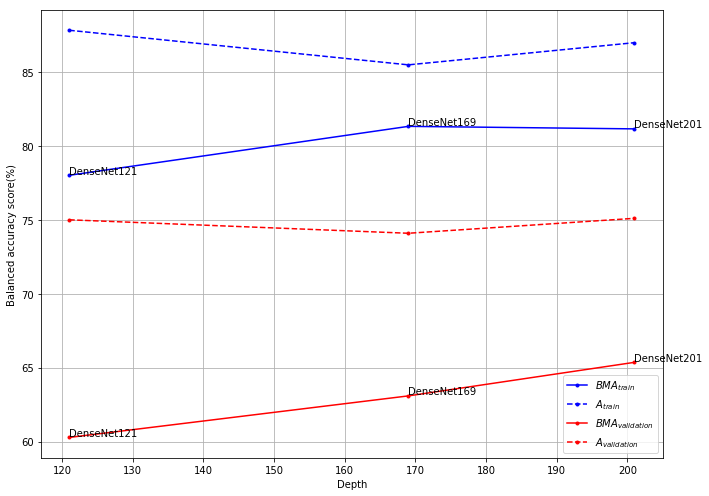

In [118]:
model_layers = {
    "DenseNet121": 121,
    "DenseNet169": 169,
    "DenseNet201": 201,
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)
print(filtered_models_info)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(10,7)
)

fig.savefig(os.path.join("densenet_depth.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

{'model': 'ResNet152', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '11'}, 'log': '../history/ResNet152/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/0/training.csv', 'pred_test_0': '../test_predict_results/ResNet152/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/0', 'pred_test': '../test_predict_results/ResNet152/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11'}
{'model': 'ResNet50', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '11'}, 'log': '../history/ResNet50/balanced_0

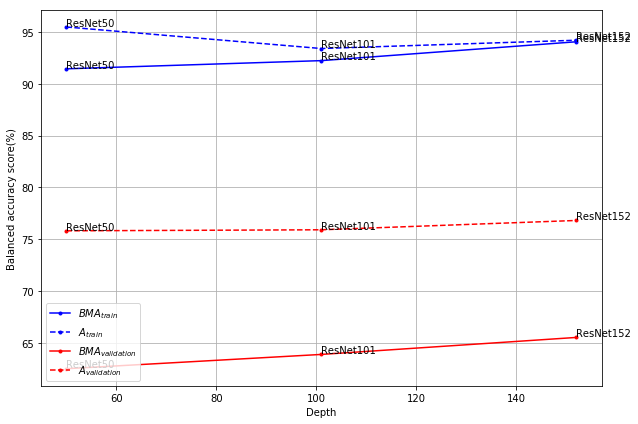

In [171]:
# Trainable params
model_layers = {
    "ResNet50": 50,
    "ResNet101": 101,
    "ResNet152": 152
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(9,6)
)

fig.savefig(os.path.join("resnet_depth.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

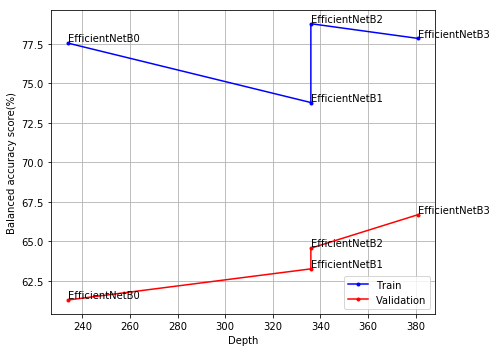

In [97]:
# Trainable params
model_layers = {
    'EfficientNetB0': 234,  
    "EfficientNetB1": 336,
    'EfficientNetB2': 336,
    'EfficientNetB3': 381,
    'EfficientNetB4': 471,
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(7,5)
)

{'model': 'ResNet152', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/ResNet152/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_test_0': None, 'pred_test': '../test_predict_results/ResNet152/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01'}
{'model': 'ResNet50', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/ResNet50/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_test_0': None, 'pred

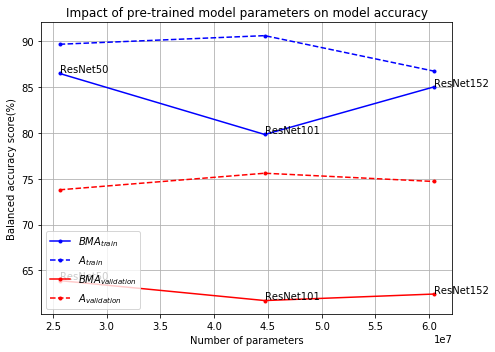

In [145]:
# Trainable params
model_layers = {
    "ResNet50": 25636712,
    "ResNet101": 44707176,
    "ResNet152": 60419944
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

{'model': 'DenseNet201', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_test_0': '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0', 'pred_test': '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01'}
{'model': 'DenseNet121', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/DenseNet

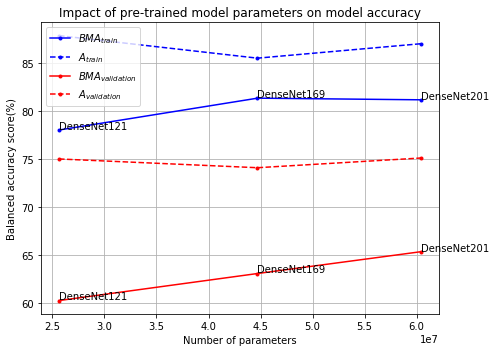

In [144]:
# Trainable params
model_layers = {
    "DenseNet121": 25636712,
    "DenseNet169": 44707176,
    "DenseNet201": 60419944
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftlr": "0.001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "01"
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

ValueError: not enough values to unpack (expected 4, got 0)

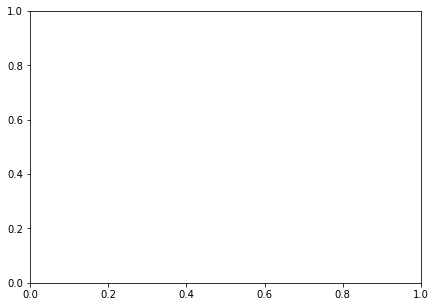

In [138]:
# Trainable params
model_layers = {
    'VGG16': 138357544, 
    'VGG19': 143667240, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 16
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

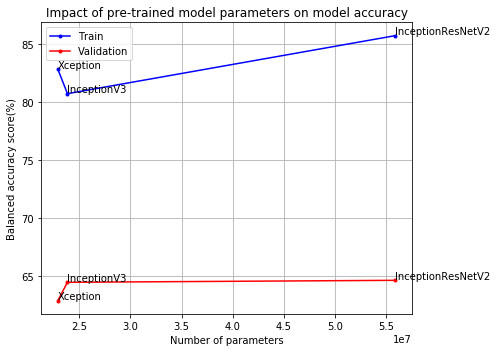

In [94]:
# Trainable params
model_layers = {
    'Xception': 22910480,  
    "InceptionV3": 23851784,
    'InceptionResNetV2': 55873736, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

{'model': 'EfficientNetB0', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '11'}, 'log': '../history/EfficientNetB0/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/0/training.csv', 'pred_test_0': '../test_predict_results/EfficientNetB0/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/0', 'pred_test': '../test_predict_results/EfficientNetB0/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11'}
{'model': 'EfficientNetB3', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '0', 'ftepochs': '100', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '11'}, 'log': '../h

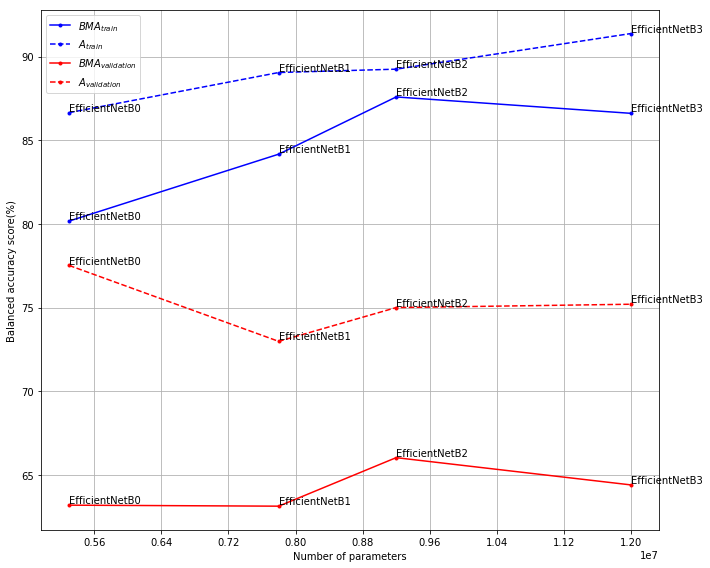

In [184]:
# Trainable params
model_layers = {
    'EfficientNetB0': 5300000,  
    "EfficientNetB1": 7800000,
    'EfficientNetB2': 9200000, 
    'EfficientNetB3': 12000000, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="",
    figsize=(10,8),
    x_int_ticks=True
)

#fig.savefig(os.path.join("efficientnet_params.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

## DenseNet201 - Confusion Matrix

Model selection criteria: best_balanced_acc

Train + validation sampled: 5000
Feature extract epochs: 0
Feature extract learning rate: 0.000100
Fine tuning learning rate: 0.000100
Dropout rate: None
Batch size: 32
	accuracy:  0.7420564436550227
	balanced_accuracy_score:  0.579451988235506


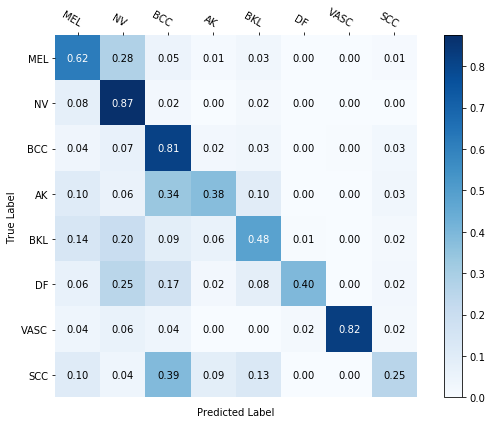

In [56]:
model_name = 'DenseNet201'
postfix = 'best_balanced_acc'

print(f'Model selection criteria: {postfix}\n')

model_info = filter_models_info(
    models_info, 
    models=["DenseNet201"],
    parameters={
        "samples": 5000,
        "balanced": 0,
        "lambda": None,
        "feepochs": 0, 
        "felr": 0.0001, 
        "ftlr": 0.0001, 
        "batch": 32,
        "dropout": None
    }
)[0]

print(f"Train + validation sampled: {model_info['hyperparameters']['samples']}")
print(f"Feature extract epochs: {model_info['hyperparameters']['feepochs']}")
print(f"Feature extract learning rate: {model_info['hyperparameters']['felr']}")
print(f"Fine tuning learning rate: {model_info['hyperparameters']['ftlr']}")
print(f"Dropout rate: {model_info['hyperparameters']['dropout']}")
print(f"Batch size: {model_info['hyperparameters']['batch']}")

# Load predicted results
df_pred = pd.read_csv(os.path.join(model_info["pred_test"], "no_unknown", f"{postfix}.csv"))
df = pd.merge(df_pred, df_all_ground_truth, on='image')
y_true = df['category']
y_pred = df['pred_category']
df.to_csv("test.csv")

# Compute Balanced Accuracy
print('\taccuracy: ', accuracy_score(y_true, y_pred))
print('\tbalanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))

# Confusion Matrix
fig = plot_confusion_matrix(
    y_true, 
    y_pred, 
    known_category_names, 
    normalize=True,
    figsize=(8, 6)
)

fig.savefig(os.path.join("densenet201_untuned_conf_matrix.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

(2534,)
(2534,)
========== Ground Truth ==========
Ground turth set has 2534 samples.

'MEL':	452	(17.84%)
'NV':	1288	(50.83%)
'BCC':	332	(13.10%)
'AK':	87	(3.43%)
'BKL':	263	(10.38%)
'DF':	24	(0.95%)
'VASC':	25	(0.99%)
'SCC':	63	(2.49%)

========== Prediction ==========
'MEL':	402	(15.86%)
'NV':	1320	(52.09%)
'BCC':	416	(16.42%)
'AK':	98	(3.87%)
'BKL':	201	(7.93%)
'DF':	21	(0.83%)
'VASC':	26	(1.03%)
'SCC':	50	(1.97%)
'UNK':	0	(0.00%)


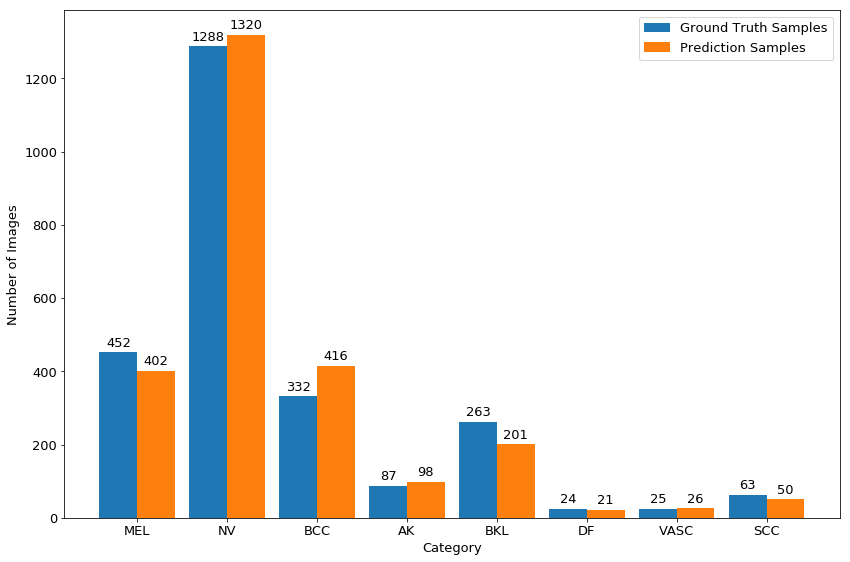

In [24]:
import matplotlib 

font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

model_folder = 'models_proper'
history_folder = 'history_proper'
pred_result_folder_test = 'test_predict_results_proper'

ground_truth, _, _ = load_isic_training_data(
    "../data/isic2019/sampled_unbalanced_5000_proper/ISIC_2019_Test_Input", 
    "../data/isic2019/sampled_unbalanced_5000_proper/ISIC_2019_Test_GroundTruth.csv"
)

# Load predicted results
file_path = os.path.join("..", pred_result_folder_test, "DenseNet201", "balanced_0-samples_5000-feepochs_2-ftepochs_100-felr_0.001000-ftlr_0.000100-lambda_None-dropout_None-batch_8-dggroup_11", "no_unknown", "best_balanced_acc.csv")

df_pred = pd.read_csv(file_path)
df = pd.merge(ground_truth, df_pred, on='image')
y_true = df['category']
y_pred = df['pred_category']

print(y_true.shape)
print(y_pred.shape)


print('========== Ground Truth ==========')
sample_count_val = y_true.shape[0]
print("Ground turth set has {} samples.\n".format(sample_count_val))

count_true = Counter(y_true)
for i, c in enumerate(known_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_true[i], count_true[i]*100/sample_count_val))

print("\n========== Prediction ==========")
count_pred = Counter(y_pred)
for i, c in enumerate(known_category_names+[unknown_category_name]):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_pred[i], count_pred[i]*100/sample_count_val))

# Plot Prediction Distribution
fig = plot_grouped_2bars(
    scalars=[[count_true[i] for i in range(known_category_num)],
             [count_pred[i] for i in range(known_category_num)]],
    scalarlabels=['Ground Truth Samples', 'Prediction Samples'],
    xticklabels=known_category_names,
    xlabel='Category',
    ylabel='Number of Images',
    figsize=(12,8)
)

fig.savefig(os.path.join("densenet201_pred_dist.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

In [11]:
import matplotlib 
from visuals import *
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

model_info=filter_models_info(
    models_info, 
    models=["DenseNet201"], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftepochs": "100",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "11"
    }
)[0]

fig = plot_checkpoint_comparisson(
    model_info, 
    df_all_ground_truth,
    figsize = (12,14),
    y_max=None
)


FileNotFoundError: [Errno 2] File ../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/no_unknown/best_loss.csv does not exist: '../test_predict_results/DenseNet201/balanced_0-samples_5000-feepochs_0-ftepochs_100-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_11/no_unknown/best_loss.csv'